In [24]:
import sys
import math
import numpy as np
from scipy import ndimage as ndi
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib import image as img
from matplotlib import patches as pat
from itertools import permutations
from netCDF4 import Dataset
import cartopy.crs as ccrs
import os
import fnmatch
Inbox = "../input/goes-l1/GOES_ABIL1nc/"

In [25]:
# Function - realce_lineal
def realce_lineal(x1,x2,vector):
    Rarray=(vector-x1)/(x2-x1)
    Rarray[Rarray<0]=0.
    Rarray[Rarray>1]=1.
    return Rarray

# Function - muestreo.
def muestreo(x,y,z,esc=1,kind='cubic'):
    f = interpolate.interp2d(x, y, z, kind='cubic')
    xnew = np.arange(x[0],x[-1], (x[1]-x[0])/esc)
    ynew = np.arange(y[0],y[-1], (y[1]-y[0])/esc)
    return xnew,ynew,f(xnew, ynew)

In [26]:
hora = 's20180961500406' #s20183471515
#img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en m
img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
psize = 500 # lado de pixel de referencia en m
N = 5424*4 #numero de pixeles de referencia

filas = 1440 # filas del recorte para la de referencia
columnas = 1440 # filas del recorte para la de referencia

x0=1438000 # Coordenada x del limite superior izquierdo en m
y0=-2441000 # Coordenada y del limite superior izquierdo en m

img_extentr = [x0,x0+columnas*psize,y0-filas*psize,y0]

In [27]:
canal =['C02','C03','C01']

channels_vapor = ['C08','C09','C10']
channels_cas = ['C04','C06','C07']
channels_las = ['C06','C07','C13']
channels_surface = ['C07','C06','C13']

imagRGB = np.zeros([filas, columnas,3])

vapor_image = np.zeros([filas, columnas,3])
cas_image = np.zeros([filas, columnas,3])
las_image = np.zeros([filas, columnas,3])
surface_image = np.zeros([filas, columnas,3])

Importando la imagen: OR_ABI-L1b-RadF-M3C08_G16_s20180961500406_e20180961511173_c20180961511220.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C08_G16_s20180961500406_e20180961511173_c20180961511220.nc
Canal 8


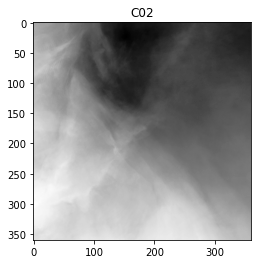

Calibrando la imagen
Interpolando
Realzando
Graficando


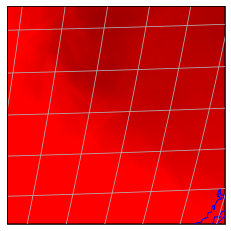

Importando la imagen: OR_ABI-L1b-RadF-M3C09_G16_s20180961500406_e20180961511178_c20180961511238.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C09_G16_s20180961500406_e20180961511178_c20180961511238.nc
Canal 9


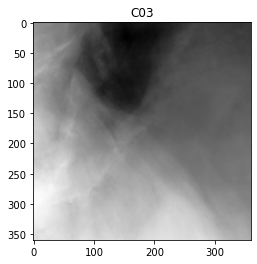

Calibrando la imagen
Interpolando
Realzando
Graficando


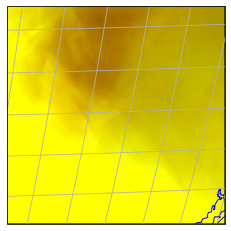

Importando la imagen: OR_ABI-L1b-RadF-M3C10_G16_s20180961500406_e20180961511184_c20180961511233.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C10_G16_s20180961500406_e20180961511184_c20180961511233.nc
Canal 10


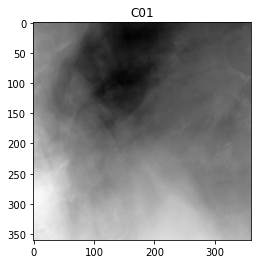

Calibrando la imagen
Interpolando
Realzando
Graficando


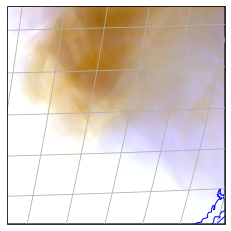

In [28]:

for i in range(3):
    
    for file_name in os.listdir(Inbox):
        if fnmatch.fnmatch(file_name, '*'+channels_vapor[i]+'*'+hora+'*'):
            img_name=file_name
            
            print ('Importando la imagen: %s' %img_name)
            imagenobj = Dataset(Inbox + img_name, 'r')

            print ('Importando las variables de la imagen: %s' %img_name)
            metadato = imagenobj.variables
            altura=metadato['goes_imager_projection'].perspective_point_height
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin
            pol=semieje_may*altura/(semieje_may+altura)
            ecu=semieje_men*altura/(semieje_may+altura)
# img_extent = (-ecu,ecu,-pol,pol)
# img_extent = (-pol,pol,-ecu,ecu)
            icanal = int(metadato['band_id'][:])
            print ('Canal %d' %icanal)

# Recortes crudos
            esc=int(N/metadato['Rad'][:].shape[0])
            Nx=int(columnas/esc) #numero de puntos del recorte en x
            Ny=int(filas/esc) #numero de puntos del recorte en x
            f0=int((-y0/psize+N/2-1.5)/esc) #fila del angulo superior izquierdo
            c0=int((x0/psize+N/2+.5)/esc) #columna del angulo superior izquierdo
            f1=int(f0+Ny) #fila del angulo inferior derecho
            c1=int(c0+Nx) #columna del angulo inferior derecho

            im_rec = metadato['Rad'][:].data[f0:f1,c0:c1]

            plt.figure()
            vmin=im_rec.min()
            vmax=im_rec.max()

            if icanal >= 7 :
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
            else:
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys_r') #reflectivas
            plt.title(canal[i])
            plt.show()

#%%calibracion 
            print ('Calibrando la imagen')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset    
        #imag_rad =im_rec*pendiente+ordenada #DN ->mW m-2 sr-1 mum-1
            Unit = "Radiancia ["+metadato['Rad'].units+"]"

            if icanal >=7:
        #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K
                fk2 = metadato['planck_fk2'][0]
                bc1 = metadato['planck_bc1'][0]
                bc2 = metadato['planck_bc2'][0]
                imag_cal = (fk2 / (np.log((fk1 / im_rec) + 1)) - bc1 ) / bc2-273.15 # DN -> C
                Unit = "Temperatura de Brillo [°C]"
            else:
                k0=imagenobj.variables['kappa0'][0]
                imag_cal = im_rec*k0
                Unit = "Reflectancia"
    
    # print (imagenobj.variables['max_radiance_value_of_valid_pixels'][0])
            print('Interpolando')
            x,y,imag_calm =muestreo(range(f0,f1),range(c0,c1),imag_cal,esc=esc)

            print('Realzando')
            vmin=0
            vmax=imag_calm[1000:,:600].max()
            imag_calm=realce_lineal(vmin,vmax,imag_calm)

            vapor_image[:imag_calm.shape[0],:imag_calm.shape[1],i]=imag_calm
    
            del imag_cal,im_rec
        
            print("Graficando")
            plt.figure()
            crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura) #proyeccion geoestacionaria para Goes16
            ax = plt.axes(projection=crs)
            # ax = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_cen)) #proyeccion geoestacionaria para Goes16
            ax.gridlines() #agrega linea de meridianos y paralelos 
            ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa
            img = plt.imshow(vapor_image,extent=img_extentr)
            plt.show()

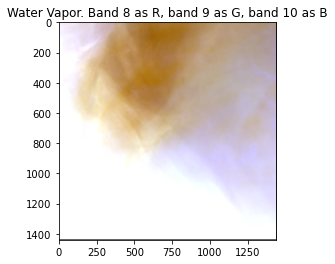

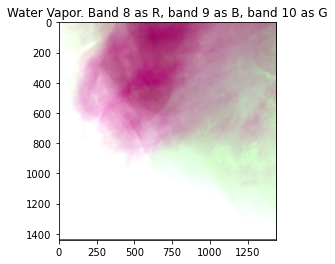

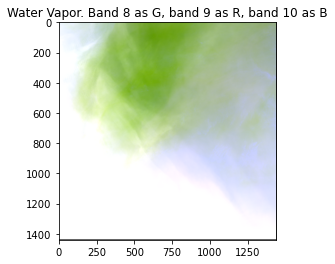

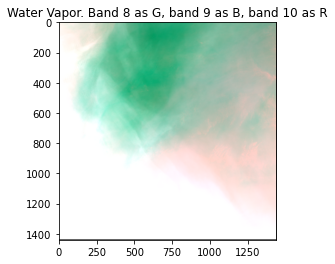

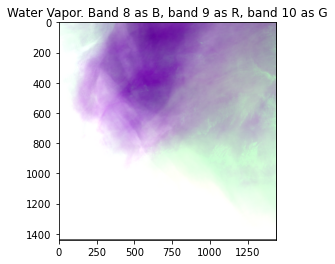

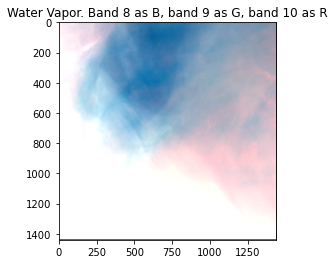

In [29]:
image_shower = np.zeros([filas,columnas,3])
perm = list(permutations(range(3)))
rgb_link = ['R', 'G', 'B']
for index in range(6):
    image_shower[:, :, perm[index][0]] = vapor_image[:, :, 0]
    image_shower[:, :, perm[index][1]] = vapor_image[:, :, 1]
    image_shower[:, :, perm[index][2]] = vapor_image[:, :, 2]

    plt.figure(frameon=False)
    plt.title('Water Vapor. Band 8 as ' + rgb_link[perm[index][0]] + ', band 9 as ' + rgb_link[perm[index][1]] + ', band 10 as ' + rgb_link[perm[index][2]])
    plt.imshow(image_shower)
    plt.show()

Importando la imagen: OR_ABI-L1b-RadF-M3C04_G16_s20180961500406_e20180961511173_c20180961511197.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C04_G16_s20180961500406_e20180961511173_c20180961511197.nc
Canal 4


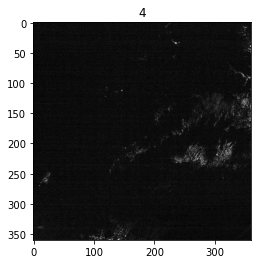

Calibrando la imagen
Interpolando
Realzando
Graficando


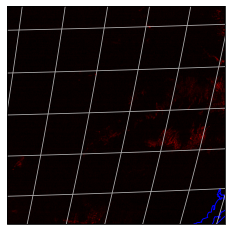

Importando la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Canal 6


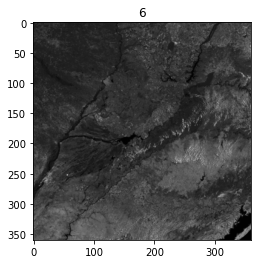

Calibrando la imagen
Interpolando
Realzando
Graficando


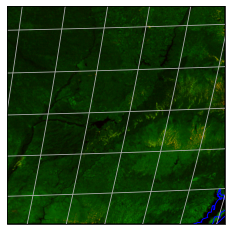

Importando la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Canal 7


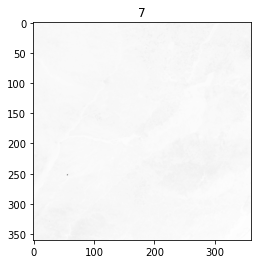

Calibrando la imagen
Interpolando
Realzando
Graficando


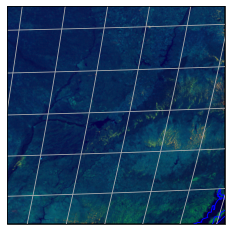

In [30]:
for i in range(3):

    for file_name in os.listdir(Inbox):
        if fnmatch.fnmatch(file_name, '*'+channels_cas[i]+'*'+hora+'*'):
            img_name=file_name
            
            print ('Importando la imagen: %s' %img_name)
            imagenobj = Dataset(Inbox + img_name, 'r')

            print ('Importando las variables de la imagen: %s' %img_name)
            metadato = imagenobj.variables
            altura=metadato['goes_imager_projection'].perspective_point_height
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin
            pol=semieje_may*altura/(semieje_may+altura)
            ecu=semieje_men*altura/(semieje_may+altura)
# img_extent = (-ecu,ecu,-pol,pol)
# img_extent = (-pol,pol,-ecu,ecu)
            icanal = int(metadato['band_id'][:])
            print ('Canal %d' %icanal)

# Recortes crudos
            esc=int(N/metadato['Rad'][:].shape[0])
            Nx=int(columnas/esc) #numero de puntos del recorte en x
            Ny=int(filas/esc) #numero de puntos del recorte en x
            f0=int((-y0/psize+N/2-1.5)/esc) #fila del angulo superior izquierdo
            c0=int((x0/psize+N/2+.5)/esc) #columna del angulo superior izquierdo
            f1=int(f0+Ny) #fila del angulo inferior derecho
            c1=int(c0+Nx) #columna del angulo inferior derecho

            im_rec = metadato['Rad'][:].data[f0:f1,c0:c1]

            plt.figure()
            vmin=im_rec.min()
            vmax=im_rec.max()

            if icanal >= 7 :
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
            else:
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys_r') #reflectivas
            plt.title(icanal)
            plt.show()

#%%calibracion 
            print ('Calibrando la imagen')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset    
        #imag_rad =im_rec*pendiente+ordenada #DN ->mW m-2 sr-1 mum-1
            Unit = "Radiancia ["+metadato['Rad'].units+"]"

            if icanal >=7:
        #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K
                fk2 = metadato['planck_fk2'][0]
                bc1 = metadato['planck_bc1'][0]
                bc2 = metadato['planck_bc2'][0]
                imag_cal = (fk2 / (np.log((fk1 / im_rec) + 1)) - bc1 ) / bc2-273.15 # DN -> C
                Unit = "Temperatura de Brillo [°C]"
            else:
                k0=imagenobj.variables['kappa0'][0]
                imag_cal = im_rec*k0
                Unit = "Reflectancia"
    
    # print (imagenobj.variables['max_radiance_value_of_valid_pixels'][0])
            print('Interpolando')
            x,y,imag_calm =muestreo(range(f0,f1),range(c0,c1),imag_cal,esc=esc)

            print('Realzando')
            vmin=0
            vmax=imag_calm[1000:,:600].max()
            imag_calm=realce_lineal(vmin,vmax,imag_calm)

            cas_image[:imag_calm.shape[0],:imag_calm.shape[1],i]=imag_calm
    
            del imag_cal,im_rec
        
            print("Graficando")
            plt.figure()
            crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura) #proyeccion geoestacionaria para Goes16
            ax = plt.axes(projection=crs)
            # ax = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_cen)) #proyeccion geoestacionaria para Goes16
            ax.gridlines() #agrega linea de meridianos y paralelos 
            ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa
            img = plt.imshow(cas_image,extent=img_extentr)
            plt.show()

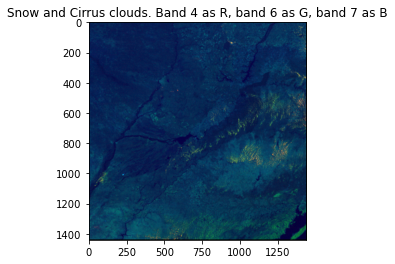

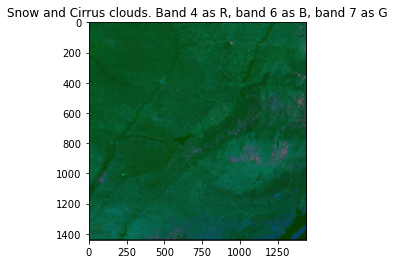

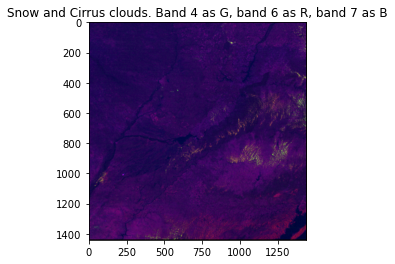

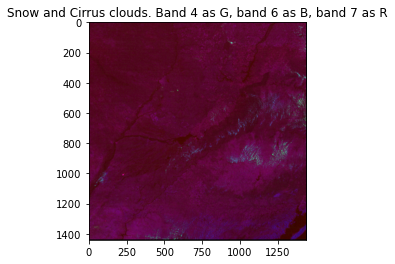

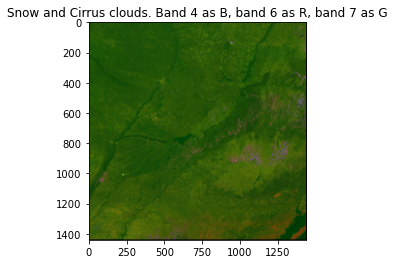

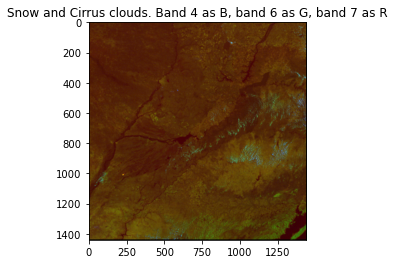

In [31]:
image_shower = np.zeros([filas,columnas,3])
perm = list(permutations(range(3)))
rgb_link = ['R', 'G', 'B']
for index in range(6):
    image_shower[:, :, perm[index][0]] = cas_image[:, :, 0]
    image_shower[:, :, perm[index][1]] = cas_image[:, :, 1]
    image_shower[:, :, perm[index][2]] = cas_image[:, :, 2]

    plt.figure(frameon=False)
    plt.title('Snow and Cirrus clouds. Band 4 as ' + rgb_link[perm[index][0]] + ', band 6 as ' + rgb_link[perm[index][1]] + ', band 7 as ' + rgb_link[perm[index][2]])
    plt.imshow(image_shower)
    plt.show()

Importando la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Canal 6


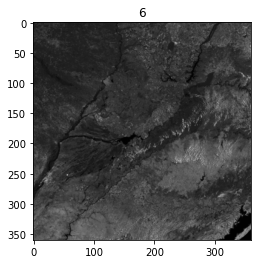

Calibrando la imagen
Interpolando
Realzando
Graficando


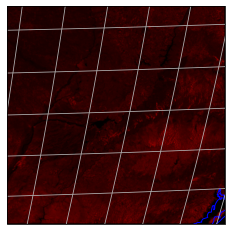

Importando la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Canal 7


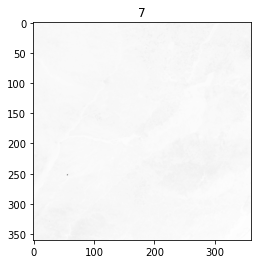

Calibrando la imagen
Interpolando
Realzando
Graficando


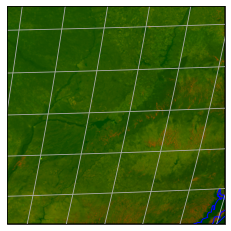

Importando la imagen: OR_ABI-L1b-RadF-M3C13_G16_s20180961500406_e20180961511184_c20180961511236.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C13_G16_s20180961500406_e20180961511184_c20180961511236.nc
Canal 13


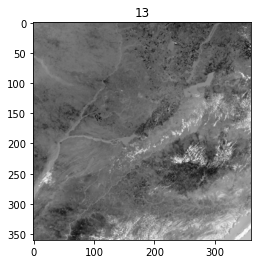

Calibrando la imagen
Interpolando
Realzando
Graficando


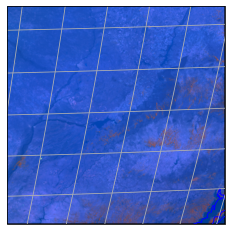

In [32]:
for i in range(3):

    for file_name in os.listdir(Inbox):
        if fnmatch.fnmatch(file_name, '*'+channels_las[i]+'*'+hora+'*'):
            img_name=file_name
            
            print ('Importando la imagen: %s' %img_name)
            imagenobj = Dataset(Inbox + img_name, 'r')

            print ('Importando las variables de la imagen: %s' %img_name)
            metadato = imagenobj.variables
            altura=metadato['goes_imager_projection'].perspective_point_height
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin
            pol=semieje_may*altura/(semieje_may+altura)
            ecu=semieje_men*altura/(semieje_may+altura)
# img_extent = (-ecu,ecu,-pol,pol)
# img_extent = (-pol,pol,-ecu,ecu)
            icanal = int(metadato['band_id'][:])
            print ('Canal %d' %icanal)

# Recortes crudos
            esc=int(N/metadato['Rad'][:].shape[0])
            Nx=int(columnas/esc) #numero de puntos del recorte en x
            Ny=int(filas/esc) #numero de puntos del recorte en x
            f0=int((-y0/psize+N/2-1.5)/esc) #fila del angulo superior izquierdo
            c0=int((x0/psize+N/2+.5)/esc) #columna del angulo superior izquierdo
            f1=int(f0+Ny) #fila del angulo inferior derecho
            c1=int(c0+Nx) #columna del angulo inferior derecho

            im_rec = metadato['Rad'][:].data[f0:f1,c0:c1]

            plt.figure()
            vmin=im_rec.min()
            vmax=im_rec.max()

            if icanal >= 7 :
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
            else:
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys_r') #reflectivas
            plt.title(icanal)
            plt.show()

#%%calibracion 
            print ('Calibrando la imagen')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset    
        #imag_rad =im_rec*pendiente+ordenada #DN ->mW m-2 sr-1 mum-1
            Unit = "Radiancia ["+metadato['Rad'].units+"]"

            if icanal >=7:
        #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K
                fk2 = metadato['planck_fk2'][0]
                bc1 = metadato['planck_bc1'][0]
                bc2 = metadato['planck_bc2'][0]
                imag_cal = (fk2 / (np.log((fk1 / im_rec) + 1)) - bc1 ) / bc2-273.15 # DN -> C
                Unit = "Temperatura de Brillo [°C]"
            else:
                k0=imagenobj.variables['kappa0'][0]
                imag_cal = im_rec*k0
                Unit = "Reflectancia"
    
    # print (imagenobj.variables['max_radiance_value_of_valid_pixels'][0])
            print('Interpolando')
            x,y,imag_calm =muestreo(range(f0,f1),range(c0,c1),imag_cal,esc=esc)

            print('Realzando')
            vmin=0
            vmax=imag_calm[1000:,:600].max()
            imag_calm=realce_lineal(vmin,vmax,imag_calm)

            las_image[:imag_calm.shape[0],:imag_calm.shape[1],i]=imag_calm
    
            del imag_cal,im_rec
        
            print("Graficando")
            plt.figure()
            crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura) #proyeccion geoestacionaria para Goes16
            ax = plt.axes(projection=crs)
            # ax = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_cen)) #proyeccion geoestacionaria para Goes16
            ax.gridlines() #agrega linea de meridianos y paralelos 
            ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa
            img = plt.imshow(las_image,extent=img_extentr)
            plt.show()

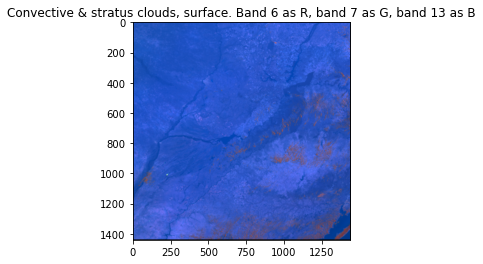

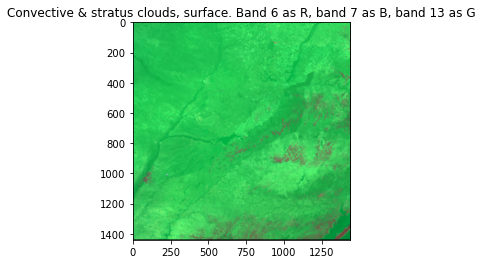

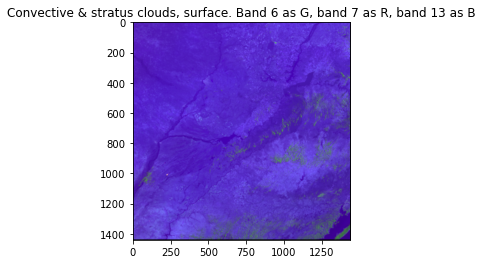

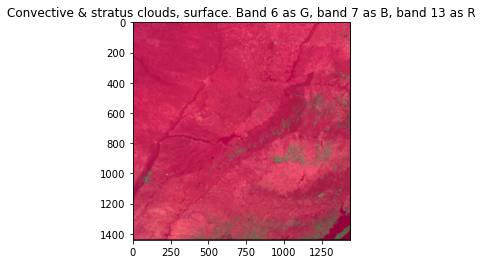

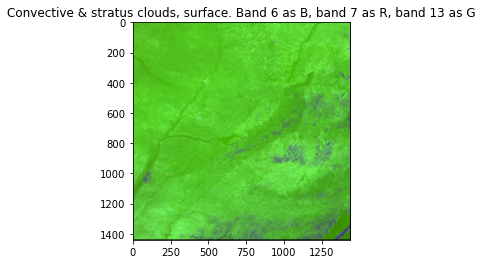

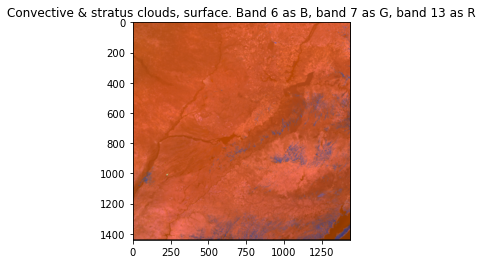

In [33]:
image_shower = np.zeros([filas,columnas,3])
perm = list(permutations(range(3)))
rgb_link = ['R', 'G', 'B']
for index in range(6):
    image_shower[:, :, perm[index][0]] = las_image[:, :, 0]
    image_shower[:, :, perm[index][1]] = las_image[:, :, 1]
    image_shower[:, :, perm[index][2]] = las_image[:, :, 2]

    plt.figure(frameon=False)
    plt.title('Convective & stratus clouds, surface. Band 6 as ' + rgb_link[perm[index][0]] + ', band 7 as ' + rgb_link[perm[index][1]] + ', band 13 as ' + rgb_link[perm[index][2]])
    plt.imshow(image_shower)
    plt.show()

Importando la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C07_G16_s20180961500406_e20180961511184_c20180961511220.nc
Canal 7


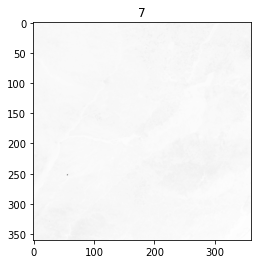

Calibrando la imagen
Interpolando
Realzando
Graficando


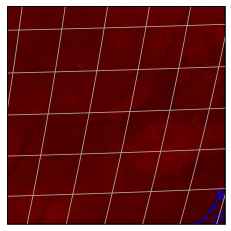

Importando la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C06_G16_s20180961500406_e20180961511178_c20180961511215.nc
Canal 6


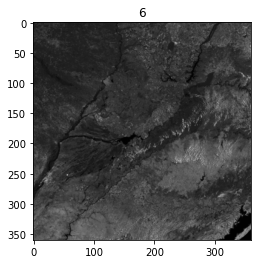

Calibrando la imagen
Interpolando
Realzando
Graficando


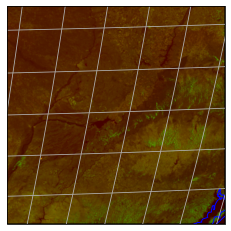

Importando la imagen: OR_ABI-L1b-RadF-M3C13_G16_s20180961500406_e20180961511184_c20180961511236.nc
Importando las variables de la imagen: OR_ABI-L1b-RadF-M3C13_G16_s20180961500406_e20180961511184_c20180961511236.nc
Canal 13


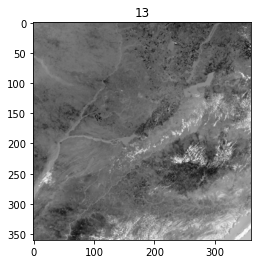

Calibrando la imagen
Interpolando
Realzando
Graficando


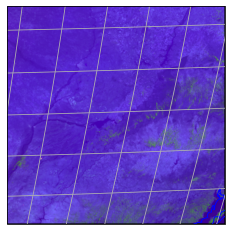

In [34]:
for i in range(3):

    for file_name in os.listdir(Inbox):
        if fnmatch.fnmatch(file_name, '*'+channels_surface[i]+'*'+hora+'*'):
            img_name=file_name
            
            print ('Importando la imagen: %s' %img_name)
            imagenobj = Dataset(Inbox + img_name, 'r')

            print ('Importando las variables de la imagen: %s' %img_name)
            metadato = imagenobj.variables
            altura=metadato['goes_imager_projection'].perspective_point_height
            semieje_may=metadato['goes_imager_projection'].semi_major_axis
            semieje_men=metadato['goes_imager_projection'].semi_minor_axis
            lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin
            pol=semieje_may*altura/(semieje_may+altura)
            ecu=semieje_men*altura/(semieje_may+altura)
# img_extent = (-ecu,ecu,-pol,pol)
# img_extent = (-pol,pol,-ecu,ecu)
            icanal = int(metadato['band_id'][:])
            print ('Canal %d' %icanal)

# Recortes crudos
            esc=int(N/metadato['Rad'][:].shape[0])
            Nx=int(columnas/esc) #numero de puntos del recorte en x
            Ny=int(filas/esc) #numero de puntos del recorte en x
            f0=int((-y0/psize+N/2-1.5)/esc) #fila del angulo superior izquierdo
            c0=int((x0/psize+N/2+.5)/esc) #columna del angulo superior izquierdo
            f1=int(f0+Ny) #fila del angulo inferior derecho
            c1=int(c0+Nx) #columna del angulo inferior derecho

            im_rec = metadato['Rad'][:].data[f0:f1,c0:c1]

            plt.figure()
            vmin=im_rec.min()
            vmax=im_rec.max()

            if icanal >= 7 :
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
            else:
                img=plt.imshow(im_rec,vmin=vmin,vmax=vmax,cmap='Greys_r') #reflectivas
            plt.title(icanal)
            plt.show()

#%%calibracion 
            print ('Calibrando la imagen')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset    
        #imag_rad =im_rec*pendiente+ordenada #DN ->mW m-2 sr-1 mum-1
            Unit = "Radiancia ["+metadato['Rad'].units+"]"

            if icanal >=7:
        #Parámetros de calibracion
                fk1 = metadato['planck_fk1'][0] # DN -> K
                fk2 = metadato['planck_fk2'][0]
                bc1 = metadato['planck_bc1'][0]
                bc2 = metadato['planck_bc2'][0]
                imag_cal = (fk2 / (np.log((fk1 / im_rec) + 1)) - bc1 ) / bc2-273.15 # DN -> C
                Unit = "Temperatura de Brillo [°C]"
            else:
                k0=imagenobj.variables['kappa0'][0]
                imag_cal = im_rec*k0
                Unit = "Reflectancia"
    
    # print (imagenobj.variables['max_radiance_value_of_valid_pixels'][0])
            print('Interpolando')
            x,y,imag_calm =muestreo(range(f0,f1),range(c0,c1),imag_cal,esc=esc)

            print('Realzando')
            vmin=0
            vmax=imag_calm[1000:,:600].max()
            imag_calm=realce_lineal(vmin,vmax,imag_calm)

            surface_image[:imag_calm.shape[0],:imag_calm.shape[1],i]=imag_calm
    
            del imag_cal,im_rec
        
            print("Graficando")
            plt.figure()
            crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura) #proyeccion geoestacionaria para Goes16
            ax = plt.axes(projection=crs)
            # ax = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_cen)) #proyeccion geoestacionaria para Goes16
            ax.gridlines() #agrega linea de meridianos y paralelos 
            ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa
            img = plt.imshow(surface_image,extent=img_extentr)
            plt.show()

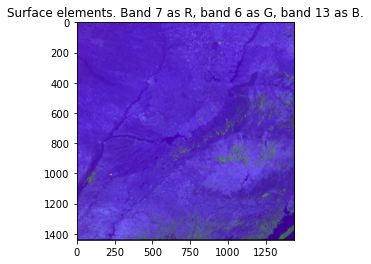

In [37]:
image_shower = np.zeros([filas,columnas,3])
image_shower[:, :, 0] = surface_image[:, :, 0]
image_shower[:, :, 1] = surface_image[:, :, 1]
image_shower[:, :, 2] = surface_image[:, :, 2]

plt.figure(frameon=False)
plt.title('Surface elements. Band 7 as R, band 6 as G, band 13 as B.')
plt.imshow(image_shower)
plt.show()

'''
Sergio, aca no pude hacer andar los patches. Pero la imagen es mas o menos la misma y a primera vista se pueden
distinguir claramente los rios. Apenas, abajo a la derecha, se puede ver uno de los lagos que marque en el 6a.

Tuve que usar el realce_lineal del archivo util_img porque el realce que habia hecho yo (que es como la funcion
realce_linealp del archivo util_img) tiraba errores de indice. Me parece que es algo parecido a lo que sucedia
en el practico 3 mio. Probe usar la funcion esa que habia armado con los try y except, pero se seguia rompiendo.
'''